# Model Metrics Visualization

This notebook visualizes precision, recall, and F1 scores for labels 0-5 from saved model metrics.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from collections import defaultdict

sys.path.append(str(Path.cwd().parent.parent))
from utils import DATA_DIR

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 5)

metrics_dir = DATA_DIR / "metrics" / "encoder"
all_json_files = list(metrics_dir.glob("*.json"))
all_json_files = [f for f in all_json_files if not f.name.startswith("finetuned")]

VALID_SPLITS = {"train", "val", "test"}

# Map: model_name -> split -> (timestamp, path, data)
split_map: dict[str, dict[str, tuple[str, Path, dict]]] = defaultdict(dict)

for f in all_json_files:
    stem = f.stem  # e.g. ridge_minilm_train_20251121_140233
    parts = stem.split("_")
    if len(parts) < 3:
        continue
    split_token = parts[-3]
    timestamp = parts[-1]
    if split_token not in VALID_SPLITS:
        continue
    model_name = "_".join(parts[:-3])
    try:
        with open(f, "r") as jf:
            data = json.load(jf)
        # Validate required header keys
        if data.get("model") != model_name or data.get("dataset") != split_token:
            print(f"Skipping {f.name}: header mismatch or missing required keys")
            continue
        # Keep only latest timestamp per model/split (lexicographically largest is fine due to YYYYMMDD_HHMMSS)
        prev = split_map[model_name].get(split_token)
        if prev is None or timestamp > prev[0]:
            split_map[model_name][split_token] = (timestamp, f, data)
    except Exception as e:
        print(f"Skipping {f.name}: parse error {e}")

models_metrics = []
for model, splits in split_map.items():
    params = None
    for pref in ["train", "val", "test"]:
        if pref in splits:
            params = splits[pref][2].get("params", {})
            break

    def _strip(d: dict | None):
        if d is None:
            return None
        return {k: v for k, v in d.items() if k not in ["model", "params", "dataset"]}

    train = _strip(splits.get("train", (None, None, None))[2])
    val = _strip(splits.get("val", (None, None, None))[2])
    test = _strip(splits.get("test", (None, None, None))[2])
    models_metrics.append(
        {
            "model": model,
            "params": params,
            "train": train,
            "val": val,
            "test": test,
        }
    )

# Ordering
MODEL_ORDER = ["random", "ridge", "rf", "svm", "catboost", "finetuned_mbert"]
EMBED_ORDER = ["minilm", "mbert"]


def _sort_key(entry):
    name = entry["model"] or ""
    parts = name.split("_")
    base = parts[0]
    emb = parts[1] if len(parts) > 1 else ""
    base_idx = MODEL_ORDER.index(base) if base in MODEL_ORDER else len(MODEL_ORDER)
    emb_idx = EMBED_ORDER.index(emb) if emb in EMBED_ORDER else len(EMBED_ORDER)
    return (base_idx, emb_idx, name)


models_metrics.sort(key=_sort_key)

print("Available models:")
for i, m in enumerate(models_metrics):
    splits = [s for s in ["train", "val", "test"] if m.get(s) is not None]
    print(f"  - [{i}] {m['model']} (splits: {', '.join(splits) if splits else 'none'})")

aggregated_models = models_metrics

Available models:
  - [0] random (splits: train, val, test)
  - [1] random_lg (splits: train, val, test)
  - [2] ridge_minilm (splits: train, val, test)
  - [3] ridge_minilm_lg (splits: train, val, test)
  - [4] ridge_mbert (splits: train, val, test)
  - [5] ridge_mbert_lg (splits: train, val, test)
  - [6] rf_minilm (splits: train, val, test)
  - [7] rf_minilm_lg (splits: train, val, test)
  - [8] rf_mbert (splits: train, val, test)
  - [9] rf_mbert_lg (splits: train, val, test)
  - [10] svm_minilm (splits: train, val, test)
  - [11] svm_mbert (splits: train, val, test)
  - [12] catboost_minilm (splits: train, val, test)
  - [13] catboost_minilm_lg (splits: train, val, test)
  - [14] catboost_mbert (splits: train, val, test)
  - [15] catboost_mbert_lg (splits: train, val, test)


## Specific model

In [ ]:
# Select a model index to visualize
MODEL_INDEX = 1 if len(aggregated_models) > 1 else 0
metrics_data = aggregated_models[MODEL_INDEX]


def extract_per_label_metrics(metrics_dict, dataset="test"):
    """
    Extract precision, recall, and F1 scores for labels 0-5 from aggregated model data.

    Args:
        metrics_dict: Aggregated model metrics dict with keys 'train','val','test'.
        dataset: Which dataset to use ('train', 'val', or 'test').

    Returns:
        DataFrame with precision, recall, F1, support per label or None if missing.
    """
    if metrics_dict.get(dataset) is None:
        print(f"Warning: {dataset} not available for this model")
        return None

    data = metrics_dict[dataset]

    precision = data.get("precision", []) + [0.0] * (6 - len(data.get("precision", [])))
    recall = data.get("recall", []) + [0.0] * (6 - len(data.get("recall", [])))
    f1 = data.get("f1", []) + [0.0] * (6 - len(data.get("f1", [])))
    support = data.get("support", []) + [0] * (6 - len(data.get("support", [])))

    df = pd.DataFrame(
        {
            "Label": range(6),
            "Precision": precision[:6],
            "Recall": recall[:6],
            "F1": f1[:6],
            "Support": support[:6],
        }
    )
    return df


train_df = extract_per_label_metrics(metrics_data, "train")
cv_df = extract_per_label_metrics(metrics_data, "val")
test_df = extract_per_label_metrics(metrics_data, "test")

print(f"Model: {metrics_data['model']}")
print(f"Parameters: {metrics_data['params']}")

Model: ridge_minilm
Parameters: {'ridge_alpha': 0.01}


### Tables

In [ ]:
print("=" * 60)
print("TRAIN METRICS")
print("=" * 60)


def _styled_no_index(df):
    """
    Return a Styler that formats columns and hides the row index by CSS.
    This avoids using Styler.hide_index() which may not be available in older pandas.
    """
    fmt = {"Precision": "{:.4f}", "Recall": "{:.4f}", "F1": "{:.4f}", "Support": "{:d}"}
    # Hide the index column via CSS selectors for row headings / blank header
    return df.style.format(fmt).set_table_styles(
        [{"selector": "th.row_heading, th.blank", "props": [("display", "none")]}]
    )


if train_df is not None:
    display(_styled_no_index(train_df))
    if metrics_data.get("train") is not None:
        print(f"Accuracy: {metrics_data['train']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['train']['mse']:.4f}")

print("\n" + "=" * 60)
print("CROSS-VALIDATION METRICS")
print("=" * 60)
if cv_df is not None:
    display(_styled_no_index(cv_df))
    if metrics_data.get("val") is not None:
        print(f"Accuracy: {metrics_data['val']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['val']['mse']:.4f}")

print("\n" + "=" * 60)
print("TEST METRICS")
print("=" * 60)
if test_df is not None:
    display(_styled_no_index(test_df))
    if metrics_data.get("test") is not None:
        print(f"Accuracy: {metrics_data['test']['accuracy']:.4f}")
        print(f"MSE: {metrics_data['test']['mse']:.4f}")

TRAIN METRICS


,Label,Precision,Recall,F1,Support
0,0,1.0000,1.0000,1.0000,73
1,1,1.0000,1.0000,1.0000,42
2,2,1.0000,1.0000,1.0000,68
3,3,1.0000,1.0000,1.0000,79
4,4,1.0000,1.0000,1.0000,65
5,5,1.0000,1.0000,1.0000,65


Accuracy: 1.0000
MSE: 0.0000

CROSS-VALIDATION METRICS


,Label,Precision,Recall,F1,Support
0,0,0.6600,0.1789,0.2784,73
1,1,0.1973,0.3889,0.2525,42
2,2,0.2428,0.3675,0.2802,68
3,3,0.4226,0.3816,0.3945,79
4,4,0.4363,0.4198,0.4216,65
5,5,0.8115,0.6837,0.7271,65


Accuracy: 0.3927
MSE: 1.1561

TEST METRICS


,Label,Precision,Recall,F1,Support
0,0,0.7143,0.2041,0.3175,49
1,1,0.2692,0.5000,0.3500,28
2,2,0.3043,0.4667,0.3684,45
3,3,0.3913,0.3462,0.3673,52
4,4,0.5789,0.5000,0.5366,44
5,5,0.8140,0.7955,0.8046,44


Accuracy: 0.4580
MSE: 0.9924


### Confusion Matrix

TRAIN SET CONFUSION MATRIX


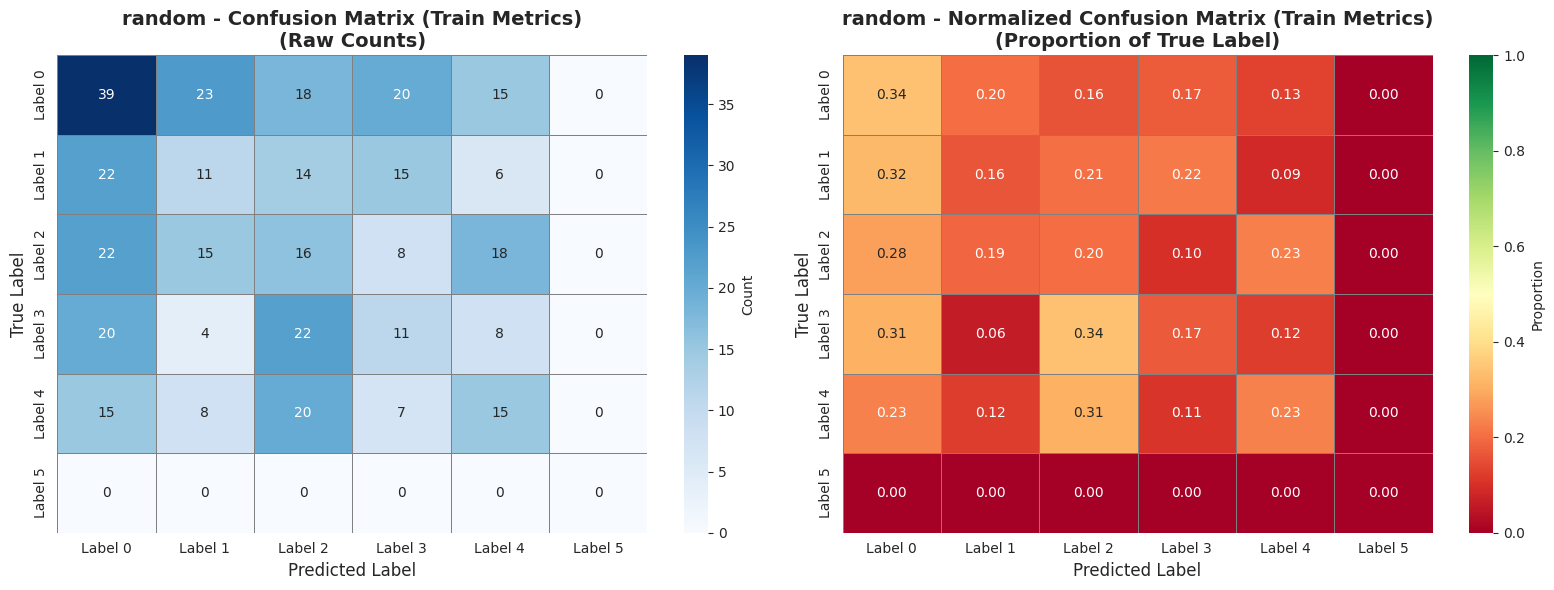


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 92
  Incorrect predictions (off-diagonal): 300
  Accuracy: 0.2347

Per-label statistics:
  Label 0: 39/115 correct (33.91%)
  Label 1: 11/68 correct (16.18%)
  Label 2: 16/79 correct (20.25%)
  Label 3: 11/65 correct (16.92%)
  Label 4: 15/65 correct (23.08%)
  Label 5: No samples

CROSS-VALIDATION CONFUSION MATRIX


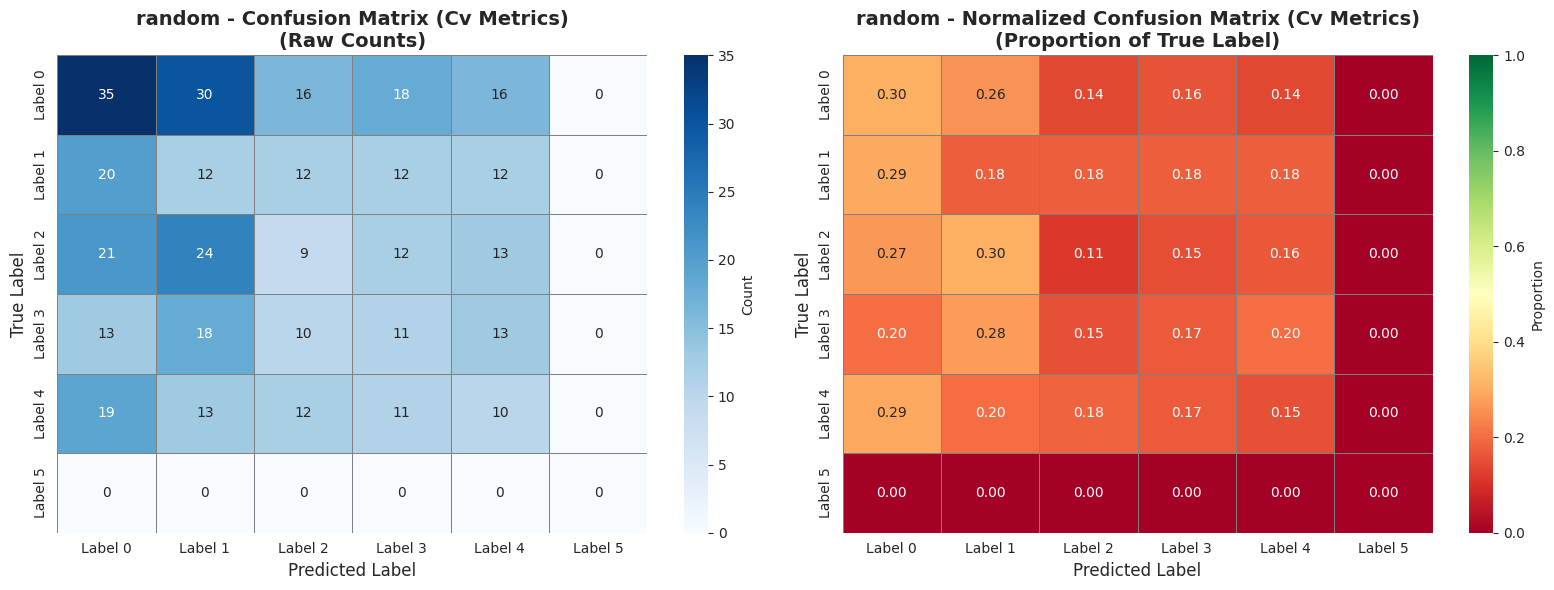


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 77
  Incorrect predictions (off-diagonal): 315
  Accuracy: 0.1964

Per-label statistics:
  Label 0: 35/115 correct (30.43%)
  Label 1: 12/68 correct (17.65%)
  Label 2: 9/79 correct (11.39%)
  Label 3: 11/65 correct (16.92%)
  Label 4: 10/65 correct (15.38%)
  Label 5: No samples

TEST SET CONFUSION MATRIX


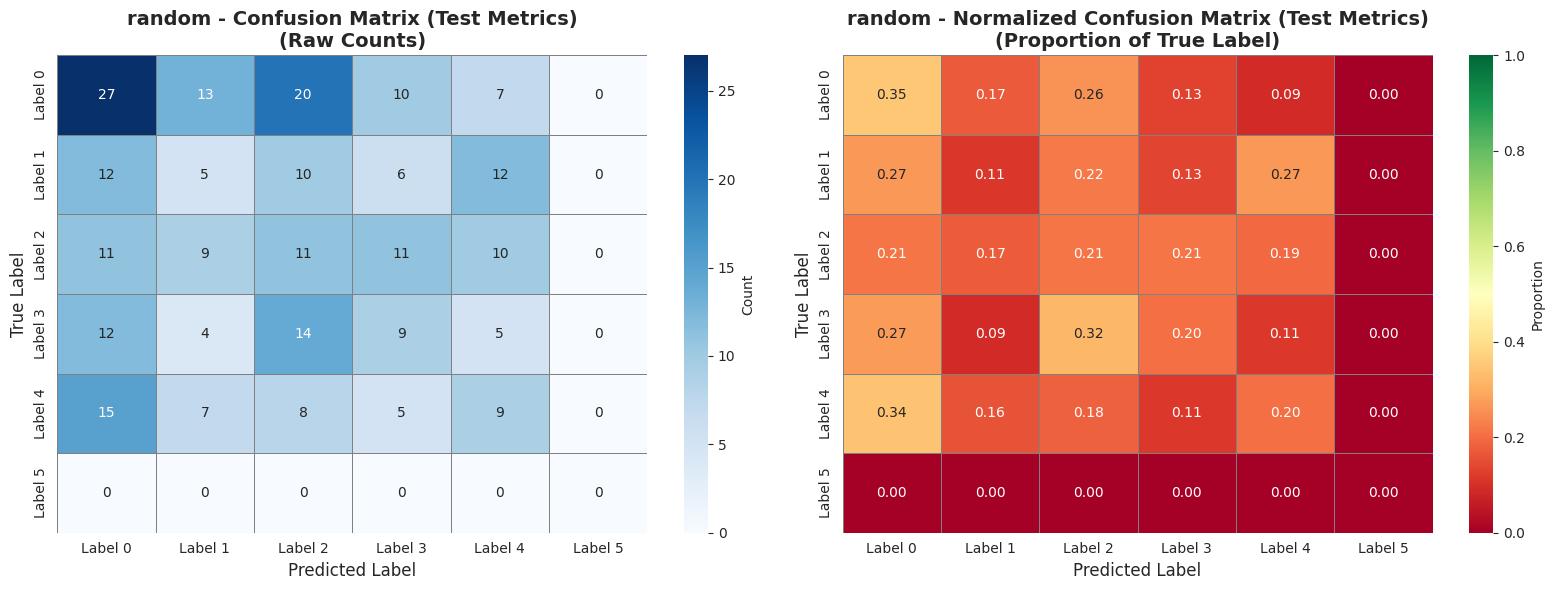


Confusion Matrix Statistics:
  Total predictions: 262
  Correct predictions (diagonal): 61
  Incorrect predictions (off-diagonal): 201
  Accuracy: 0.2328

Per-label statistics:
  Label 0: 27/77 correct (35.06%)
  Label 1: 5/45 correct (11.11%)
  Label 2: 11/52 correct (21.15%)
  Label 3: 9/44 correct (20.45%)
  Label 4: 9/44 correct (20.45%)
  Label 5: No samples


In [ ]:
def plot_confusion_matrix(metrics_dict, dataset="test"):
    """
    Plot confusion matrix showing hits (diagonal) and misses (off-diagonal).

    Args:
        metrics_dict: Dictionary containing model metrics
        dataset: Which dataset to use ('train', 'val', or 'test')
    """
    if metrics_dict[dataset] is None:
        print(f"Warning: {dataset} not available for this model")
        return

    data = metrics_dict[dataset]

    cm = np.array(data["confusion_matrix"])
    # Pad to 6x6 if needed (for label 5)
    if cm.shape[0] < 6:
        padded_cm = np.zeros((6, 6), dtype=int)
        padded_cm[: cm.shape[0], : cm.shape[1]] = cm
        cm = padded_cm

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax1,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Count"},
    )
    ax1.set_title(
        f"{metrics_dict['model']} - Confusion Matrix ({dataset.replace('_', ' ').title()})\n(Raw Counts)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.set_xlabel("Predicted Label", fontsize=12)
    ax1.set_ylabel("True Label", fontsize=12)
    ax1.set_xticklabels([f"Label {i}" for i in range(6)])
    ax1.set_yticklabels([f"Label {i}" for i in range(6)])

    # Plot 2: Normalized confusion matrix (by true label)
    cm_normalized = cm.astype("float")
    row_sums = cm.sum(axis=1, keepdims=True)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    cm_normalized = cm_normalized / row_sums

    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        ax=ax2,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Proportion"},
        vmin=0,
        vmax=1,
    )
    ax2.set_title(
        f"{metrics_dict['model']} - Normalized Confusion Matrix ({dataset.replace('_', ' ').title()})\n(Proportion of True Label)",
        fontsize=14,
        fontweight="bold",
    )
    ax2.set_xlabel("Predicted Label", fontsize=12)
    ax2.set_ylabel("True Label", fontsize=12)
    ax2.set_xticklabels([f"Label {i}" for i in range(6)])
    ax2.set_yticklabels([f"Label {i}" for i in range(6)])

    plt.tight_layout()
    plt.show()

    total = cm.sum()
    correct = np.trace(cm)
    accuracy = correct / total if total > 0 else 0

    print("\nConfusion Matrix Statistics:")
    print(f"  Total predictions: {total}")
    print(f"  Correct predictions (diagonal): {correct}")
    print(f"  Incorrect predictions (off-diagonal): {total - correct}")
    print(f"  Accuracy: {accuracy:.4f}")
    print("\nPer-label statistics:")
    for i in range(6):
        true_count = cm[i, :].sum()
        correct_count = cm[i, i]
        if true_count > 0:
            per_label_acc = correct_count / true_count
            print(
                f"  Label {i}: {correct_count}/{true_count} correct ({per_label_acc:.2%})"
            )
        else:
            print(f"  Label {i}: No samples")


print("=" * 80)
print("TRAIN SET CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "train")

print("\n" + "=" * 80)
print("CROSS-VALIDATION CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "val")

print("\n" + "=" * 80)
print("TEST SET CONFUSION MATRIX")
print("=" * 80)
plot_confusion_matrix(metrics_data, "test")

## All models

Comparing all available models...



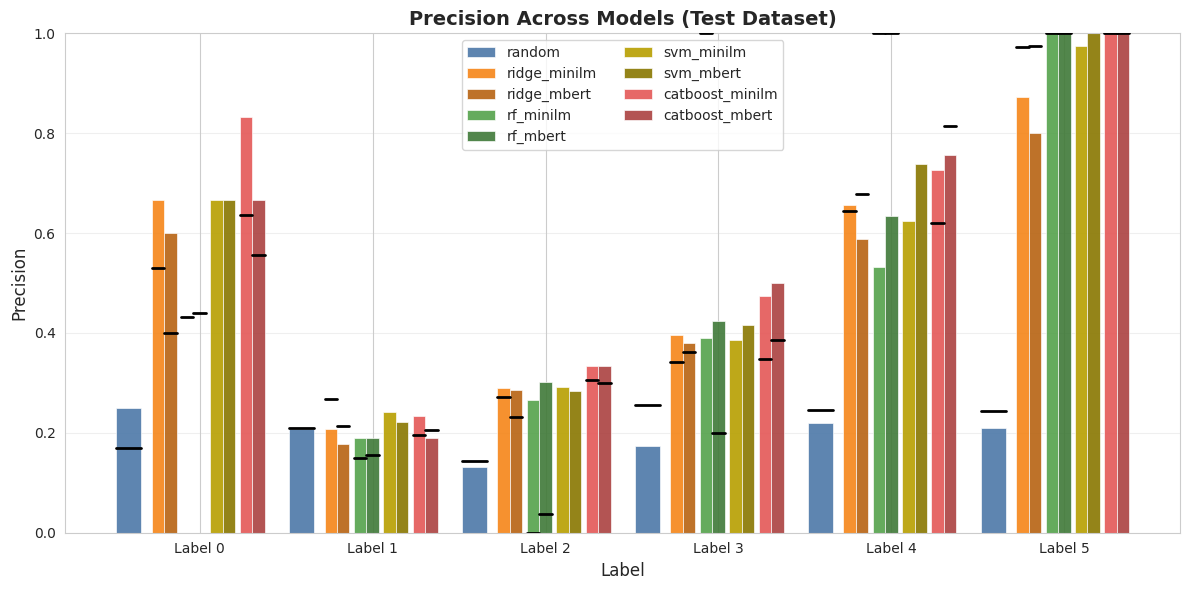

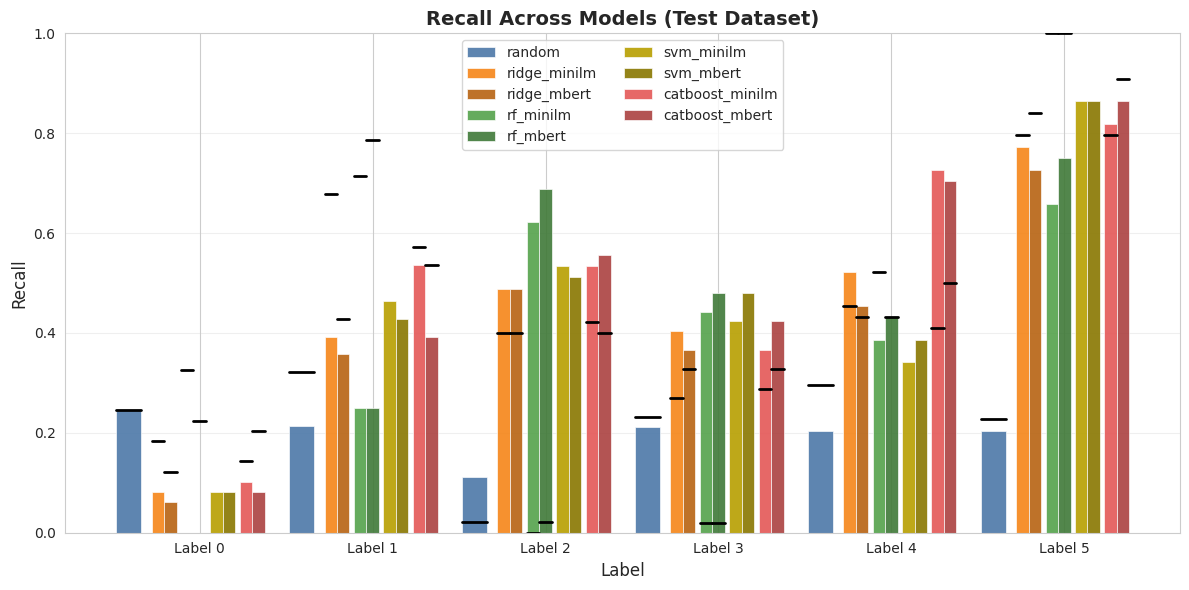

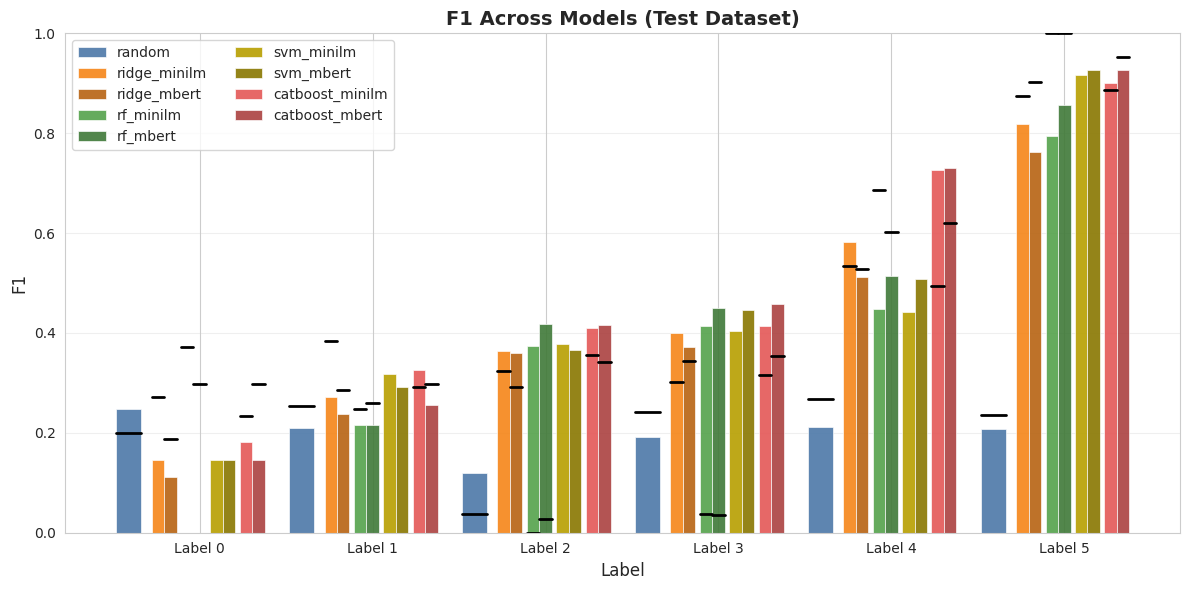

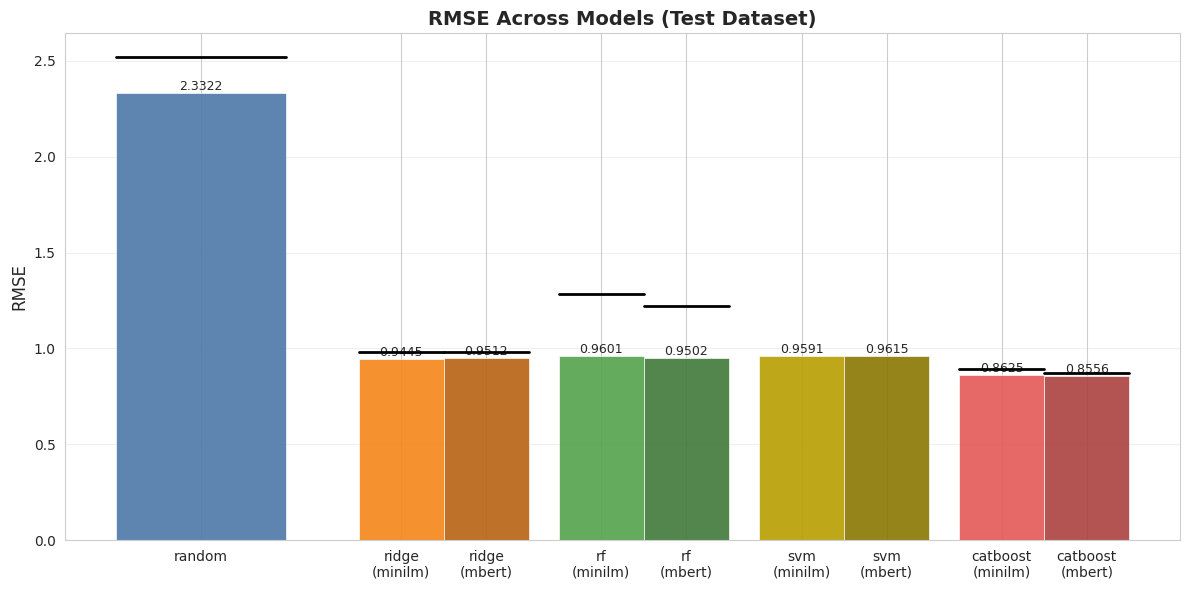

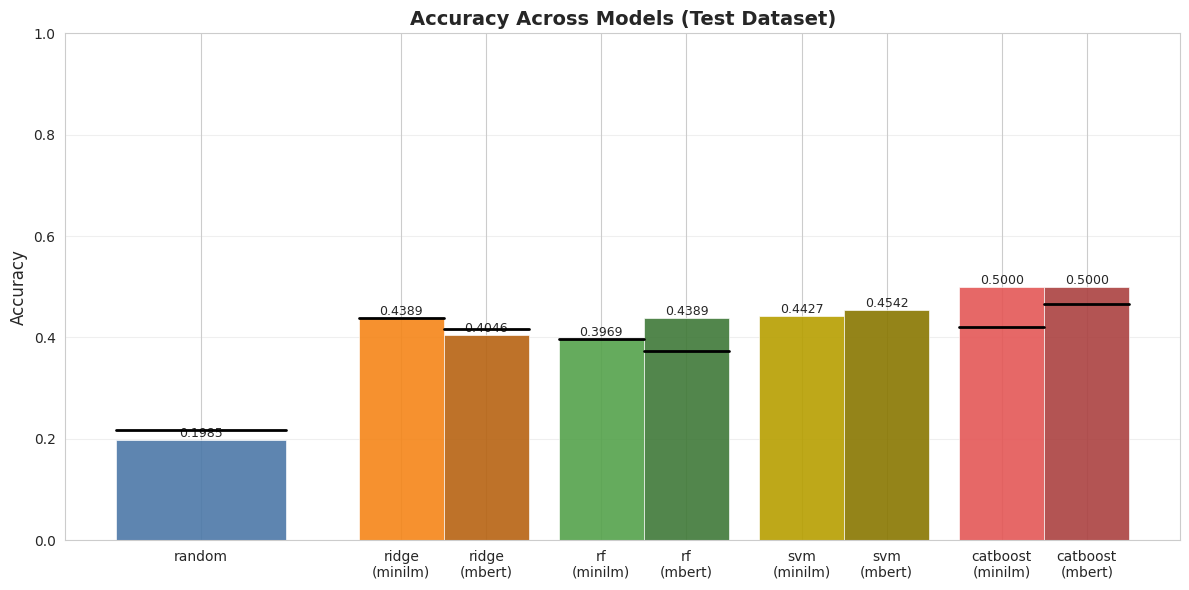

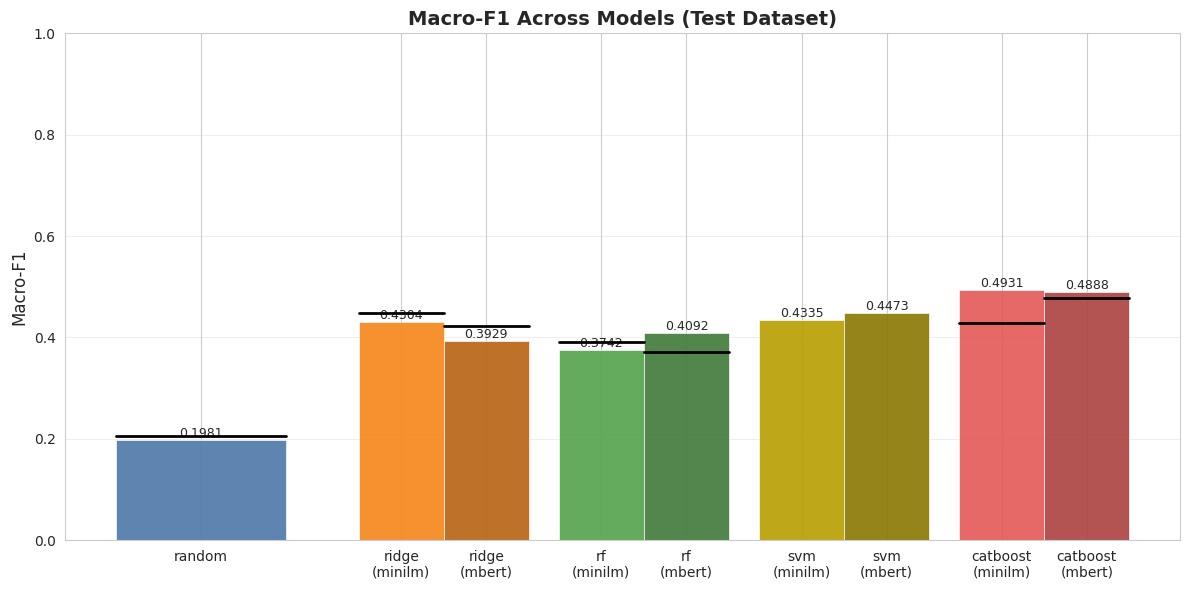

In [ ]:
def compare_models(models, dataset="test"):
    """
    Compare per-label metrics across multiple aggregated model dicts.
    Compatible with both old and new metric storage (already unified in aggregated_models).
    """
    models_data = []
    lg_models_data = []
    for m in models:
        if m.get(dataset) is not None:
            if "_lg" in m["model"]:
                lg_models_data.append({"model": m["model"], "metrics": m[dataset]})
            else:
                models_data.append({"model": m["model"], "metrics": m[dataset]})
    if not models_data:
        print(f"No models with {dataset} available")
        return

    # Create a lookup for _lg models by their base name
    lg_lookup = {}
    for lg_md in lg_models_data:
        base_name = lg_md["model"].replace("_lg", "")
        lg_lookup[base_name] = lg_md

    def parse_model(name: str):
        parts = name.split("_")
        if len(parts) >= 2:
            return parts[0], parts[1]
        return parts[0], None

    base_to_models = {}
    for md in models_data:
        base, emb = parse_model(md["model"])
        base_to_models.setdefault(base, []).append((emb, md))

    try:
        ordered_bases = [b for b in MODEL_ORDER if b in base_to_models]
        ordered_bases += [b for b in base_to_models.keys() if b not in ordered_bases]
    except NameError:
        ordered_bases = list(base_to_models.keys())

    for base in ordered_bases:
        embeds_present = [emb for emb, _ in base_to_models[base]]
        try:
            ordered_embeds = [e for e in EMBED_ORDER if e in embeds_present]
            ordered_embeds += [e for e in embeds_present if e not in ordered_embeds]
        except NameError:
            ordered_embeds = embeds_present
        md_map = {emb: md for emb, md in base_to_models[base]}
        base_to_models[base] = [(emb, md_map[emb]) for emb in ordered_embeds]

    base_colors = {
        "random": "#4C78A8",
        "ridge": "#F58518",
        "rf": "#54A24B",
        "svm": "#B79F00",
        "catboost": "#E45756",
        "finetuned": "#7F3C8D",
        "finetuned_mbert": "#7F3C8D",
    }

    def darken(hex_color, factor=0.75):
        hex_color = hex_color.lstrip("#")
        r = int(hex_color[0:2], 16)
        g = int(hex_color[2:4], 16)
        b = int(hex_color[4:6], 16)
        r = int(r * factor)
        g = int(g * factor)
        b = int(b * factor)
        return f"#{r:02x}{g:02x}{b:02x}"

    total_cluster_width = 0.85
    n_bases = len(ordered_bases)
    base_slot_width = total_cluster_width / n_bases if n_bases else 0.0
    base_slot_margin_factor = 0.15

    for metric_name in ["Precision", "Recall", "F1"]:
        fig, ax = plt.subplots(figsize=(12, 6))
        for base_idx, base in enumerate(ordered_bases):
            variants = base_to_models[base]
            n_variants = len(variants)
            inner_width = base_slot_width * (1 - base_slot_margin_factor)
            bar_width = inner_width / n_variants if n_variants else inner_width * 0.5
            base_center_offset = -total_cluster_width / 2 + base_slot_width * (
                base_idx + 0.5
            )
            for v_idx, (emb, md) in enumerate(variants):
                metric_key = metric_name.lower()
                values = md["metrics"].get(metric_key, [])
                values = values + [0.0] * (6 - len(values))
                base_positions = np.arange(6) + base_center_offset
                variant_offset_start = -inner_width / 2 + v_idx * bar_width
                x_positions = base_positions + variant_offset_start
                c = base_colors.get(base, "#888888")
                if emb == "mbert":
                    c = darken(c)
                ax.bar(
                    x_positions,
                    values[:6],
                    width=bar_width,
                    label=md["model"],
                    alpha=0.9,
                    color=c,
                    edgecolor="white",
                    linewidth=0.5,
                )

                # Add horizontal line for _lg variant if exists
                lg_md = lg_lookup.get(md["model"])
                if lg_md is not None:
                    lg_values = lg_md["metrics"].get(metric_key, [])
                    lg_values = lg_values + [0.0] * (6 - len(lg_values))
                    for label_idx in range(6):
                        x_pos = x_positions[label_idx]
                        lg_val = lg_values[label_idx]

                        # Draw line within or above the bar
                        line_y = lg_val
                        line_left = x_pos - bar_width / 2
                        line_right = x_pos + bar_width / 2

                        ax.plot(
                            [line_left, line_right],
                            [line_y, line_y],
                            color="black",
                            linewidth=2,
                            zorder=10,
                        )

        ax.set_xlabel("Label", fontsize=12)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.set_title(
            f"{metric_name} Across Models ({dataset.replace('_', ' ').title()} Dataset)",
            fontsize=14,
            fontweight="bold",
        )
        ax.set_xticks(np.arange(6))
        ax.set_xticklabels([f"Label {i}" for i in range(6)])
        ax.set_ylim(0, 1.0)
        ax.grid(axis="y", alpha=0.3)
        handles, labels = ax.get_legend_handles_labels()
        seen = set()
        new_handles, new_labels = [], []
        for h, label in zip(handles, labels):
            if label not in seen:
                seen.add(label)
                new_handles.append(h)
                new_labels.append(label)
        ax.legend(new_handles, new_labels, fontsize=10, ncol=2)
        plt.tight_layout()
        plt.show()

    flat_models = []
    for base in ordered_bases:
        for emb, md in base_to_models[base]:
            flat_models.append((base, emb, md))

    def build_cluster_positions():
        positions = []
        for base_idx, base in enumerate(ordered_bases):
            variants = [t for t in flat_models if t[0] == base]
            n_variants = len(variants)
            inner_width = base_slot_width * (1 - base_slot_margin_factor)
            bar_width = inner_width / n_variants if n_variants else inner_width * 0.5
            base_center_offset = -total_cluster_width / 2 + base_slot_width * (
                base_idx + 0.5
            )
            for v_idx, (b, emb, md) in enumerate(variants):
                variant_offset_start = -inner_width / 2 + v_idx * bar_width
                pos = base_center_offset + variant_offset_start
                positions.append((b, emb, md, pos, bar_width))
        return positions

    n_bases = len(ordered_bases)
    clustered_positions = build_cluster_positions()
    variant_positions = [pos for _, _, _, pos, _ in clustered_positions]
    variant_labels = []
    for base, emb, md, pos, bw in clustered_positions:
        if emb is None:
            variant_labels.append(f"{base}")
        else:
            variant_labels.append(f"{base}\n({emb})")

    def plot_single_metric(metric_key, title, ylim=None, transform=None, y_label=None):
        fig, ax = plt.subplots(figsize=(12, 6))
        for base, emb, md, pos, bw in clustered_positions:
            val = md["metrics"].get(metric_key)
            if val is None:
                continue
            if transform:
                val = transform(val)
            c = base_colors.get(base, "#888888")
            if emb == "mbert":
                c = darken(c)
            bar = ax.bar(
                [pos],
                [val],
                width=bw,
                color=c,
                alpha=0.9,
                edgecolor="white",
                linewidth=0.5,
            )[0]
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{val:.4f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

            # Add horizontal line for _lg variant if exists
            lg_md = lg_lookup.get(md["model"])
            if lg_md is not None:
                lg_val = lg_md["metrics"].get(metric_key)
                if lg_val is not None:
                    if transform:
                        lg_val = transform(lg_val)
                    line_left = pos - bw / 2
                    line_right = pos + bw / 2
                    ax.plot(
                        [line_left, line_right],
                        [lg_val, lg_val],
                        color="black",
                        linewidth=2,
                        zorder=10,
                    )

        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.set_ylabel(y_label if y_label else metric_key.title(), fontsize=12)
        ax.grid(axis="y", alpha=0.3)
        if ylim:
            ax.set_ylim(*ylim)
        ax.set_xticks(variant_positions)
        ax.set_xticklabels(variant_labels, fontsize=10)
        plt.tight_layout()
        plt.show()

    plot_single_metric(
        "mse",
        f"RMSE Across Models ({dataset.replace('_', ' ').title()} Dataset)",
        transform=lambda x: np.sqrt(x),
        y_label="RMSE",
    )
    plot_single_metric(
        "accuracy",
        f"Accuracy Across Models ({dataset.replace('_', ' ').title()} Dataset)",
        ylim=(0, 1.0),
    )

    # Macro-F1
    fig, ax = plt.subplots(figsize=(12, 6))
    for base, emb, md, pos, bw in clustered_positions:
        f1_list = md["metrics"].get("f1", [])
        if not f1_list:
            continue
        macro_f1 = np.mean(f1_list)
        c = base_colors.get(base, "#888888")
        if emb == "mbert":
            c = darken(c)
        bar = ax.bar(
            [pos],
            [macro_f1],
            width=bw,
            color=c,
            alpha=0.9,
            edgecolor="white",
            linewidth=0.5,
        )[0]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{macro_f1:.4f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

        # Add horizontal line for _lg variant if exists
        lg_md = lg_lookup.get(md["model"])
        if lg_md is not None:
            lg_f1_list = lg_md["metrics"].get("f1", [])
            if lg_f1_list:
                lg_macro_f1 = np.mean(lg_f1_list)
                line_left = pos - bw / 2
                line_right = pos + bw / 2
                ax.plot(
                    [line_left, line_right],
                    [lg_macro_f1, lg_macro_f1],
                    color="black",
                    linewidth=2,
                    zorder=10,
                )

    ax.set_title(
        f"Macro-F1 Across Models ({dataset.replace('_', ' ').title()} Dataset)",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_ylabel("Macro-F1", fontsize=12)
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", alpha=0.3)
    ax.set_xticks(variant_positions)
    ax.set_xticklabels(variant_labels, fontsize=10)
    plt.tight_layout()
    plt.show()


if len(aggregated_models) > 0:
    print("Comparing all available models...\n")
    compare_models(aggregated_models, "test")

In [8]:
all_metrics = []
for m in aggregated_models:

    def _safe(dataset, key):
        d = m.get(dataset)
        if d is None:
            return np.nan
        val = d.get(key)
        return val if val is not None else np.nan

    def _rmse(dataset):
        mse = _safe(dataset, "mse")
        return np.sqrt(mse) if not pd.isna(mse) else np.nan

    def _macro_f1(dataset):
        d = m.get(dataset)
        if d and d.get("f1"):
            return float(np.mean(d["f1"]))
        return np.nan

    all_metrics.append(
        {
            "Model": m["model"],
            "Train RMSE": _rmse("train"),
            "CV RMSE": _rmse("val"),
            "Test RMSE": _rmse("test"),
            "Train Acc": _safe("train", "accuracy"),
            "CV Acc": _safe("val", "accuracy"),
            "Test Acc": _safe("test", "accuracy"),
            "Train Macro-F1": _macro_f1("train"),
            "CV Macro-F1": _macro_f1("val"),
            "Test Macro-F1": _macro_f1("test"),
        }
    )

metrics_df = pd.DataFrame(all_metrics)

display(
    metrics_df.style.format(
        {
            "Train RMSE": "{:.4f}",
            "CV RMSE": "{:.4f}",
            "Test RMSE": "{:.4f}",
            "Train Acc": "{:.4f}",
            "CV Acc": "{:.4f}",
            "Test Acc": "{:.4f}",
            "Train Macro-F1": "{:.4f}",
            "CV Macro-F1": "{:.4f}",
            "Test Macro-F1": "{:.4f}",
        }
    ).set_caption("Model Metrics Comparison")
)

,Model,Train RMSE,CV RMSE,Test RMSE,Train Acc,CV Acc,Test Acc,Train Macro-F1,CV Macro-F1,Test Macro-F1
0,random,2.3129,2.4653,2.3322,0.1760,0.1734,0.1985,0.1762,0.1580,0.1981
1,random_lg,2.5940,2.4653,2.5179,0.1937,0.1734,0.2176,0.1668,0.1580,0.2063
2,ridge_minilm,0.5251,0.9334,0.9445,0.6760,0.4160,0.4389,0.6699,0.4110,0.4304
3,ridge_minilm_lg,0.7297,0.9972,0.9796,0.5951,0.4265,0.4389,0.5797,0.4460,0.4484
4,ridge_mbert,0.5226,0.9282,0.9512,0.6607,0.4159,0.4046,0.6502,0.4062,0.3929
5,rf_minilm,0.1424,0.9792,0.9601,0.9974,0.4109,0.3969,0.9969,0.3749,0.3742
6,rf_minilm_lg,0.1702,1.4210,1.2820,0.9802,0.3777,0.3969,0.9668,0.3764,0.3906
7,rf_mbert,0.0320,0.9728,0.9502,1.0000,0.4212,0.4389,1.0000,0.3929,0.4092
8,svm_minilm,0.2477,0.9294,0.9591,0.9260,0.4057,0.4427,0.9223,0.3951,0.4335
9,svm_mbert,0.2246,0.9335,0.9615,0.9413,0.3981,0.4542,0.9383,0.3894,0.4473


## Training Curves Visualization

This section visualizes training and validation loss curves for fine-tuning trials.

In [7]:
from models.encoder.common import TRAINING_HISTORY_DIR
import matplotlib.cm as cm


def plot_all_folds_for_multiple_cv(cv_data_list):
    """
    Plot training curves for all folds across multiple CV runs in a grid.
    Each CV run will be shown with a different shade of blue (train) and red (val).

    Args:
        cv_data_list: List of dictionaries, each containing CV training history with structure:
                      {'model': str, 'n_splits': int, 'folds': [fold_data, ...], 'filename': str}
                      where each fold_data has 'train_losses' and 'val_losses' per epoch
    """
    if not cv_data_list:
        print("No CV data provided")
        return

    # Determine the maximum number of folds across all CV runs
    max_folds = max(len(cv_data["folds"]) for cv_data in cv_data_list)

    if max_folds == 0:
        print("No folds found in any CV data")
        return

    # Create subplot grid
    n_cols = min(3, max_folds)
    n_rows = (max_folds + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    if max_folds == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes

    # Generate color palettes for train and val losses
    n_cv_runs = len(cv_data_list)

    # Create blue shades for training and red shades for validation
    train_colors = cm.Blues(np.linspace(0.4, 0.9, n_cv_runs))
    val_colors = cm.Reds(np.linspace(0.4, 0.9, n_cv_runs))

    # Plot each fold across all CV runs
    for fold_idx in range(max_folds):
        ax = axes[fold_idx] if max_folds > 1 else axes[0]

        for cv_idx, cv_data in enumerate(cv_data_list):
            folds = cv_data["folds"]

            # Skip if this CV run doesn't have this fold
            if fold_idx >= len(folds):
                continue

            fold_data = folds[fold_idx]
            label_suffix = cv_data.get("filename", f"CV {cv_idx}")

            train_losses = fold_data["train_losses"]
            val_losses = fold_data["val_losses"]

            epochs_train = list(range(1, len(train_losses) + 1))
            epochs_val = list(range(1, len(val_losses) + 1))

            if train_losses:
                ax.plot(
                    epochs_train,
                    train_losses,
                    "-o",
                    color=train_colors[cv_idx],
                    alpha=0.7,
                    linewidth=2,
                    markersize=3,
                    label=f"Train - {label_suffix}",
                )
            if val_losses:
                ax.plot(
                    epochs_val,
                    val_losses,
                    "-o",
                    color=val_colors[cv_idx],
                    linewidth=2,
                    markersize=3,
                    label=f"Val - {label_suffix}",
                )

            # Mark best epoch if available
            if "best_epoch" in fold_data:
                best_epoch = fold_data["best_epoch"]
                best_val_loss = fold_data.get("best_val_loss", None)
                if best_val_loss is not None:
                    ax.axvline(
                        x=best_epoch,
                        color=val_colors[cv_idx],
                        linestyle="--",
                        alpha=0.3,
                        linewidth=1,
                    )
                    ax.plot(
                        best_epoch,
                        best_val_loss,
                        "*",
                        color=val_colors[cv_idx],
                        markersize=10,
                        zorder=5,
                    )

        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Fold {fold_idx}", fontweight="bold")
        ax.legend(fontsize=8, loc="best")
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(max_folds, len(axes)):
        axes[idx].axis("off")

    # Create title from all model names
    model_names = [cv_data.get("model", "Unknown") for cv_data in cv_data_list]
    if len(set(model_names)) == 1:
        title = f"{model_names[0]} - All Folds ({n_cv_runs} CV runs)"
    else:
        title = f"Cross-Validation Comparison - All Folds ({n_cv_runs} runs)"

    fig.suptitle(title, fontsize=16, fontweight="bold", y=1.00)
    plt.tight_layout()
    plt.show()

### Cross-validation

In [8]:
# Find CV training history files
cv_history_files = sorted(list(TRAINING_HISTORY_DIR.glob("*_cv_*.json")))
print(f"Found {len(cv_history_files)} CV training history files:")
for f in cv_history_files:
    print(f"  - {f.name}")

Found 7 CV training history files:
  - finetuned_mbert_cv_20251119_122957.json
  - finetuned_mbert_cv_20251119_124814.json
  - finetuned_mbert_cv_20251119_131747.json
  - finetuned_mbert_cv_20251119_133420.json
  - finetuned_mbert_cv_20251119_134459.json
  - finetuned_mbert_cv_20251119_135639.json
  - finetuned_mbert_cv_20251119_142512.json


Loading CV training history from: finetuned_mbert_cv_20251119_122957.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_124814.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_131747.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_133420.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_134459.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_135639.json
  Model: finetuned_mbert, Folds: 5
Loading CV training history from: finetuned_mbert_cv_20251119_142512.json
  Model: finetuned_mbert, Folds: 5

Plotting 7 CV run(s)...



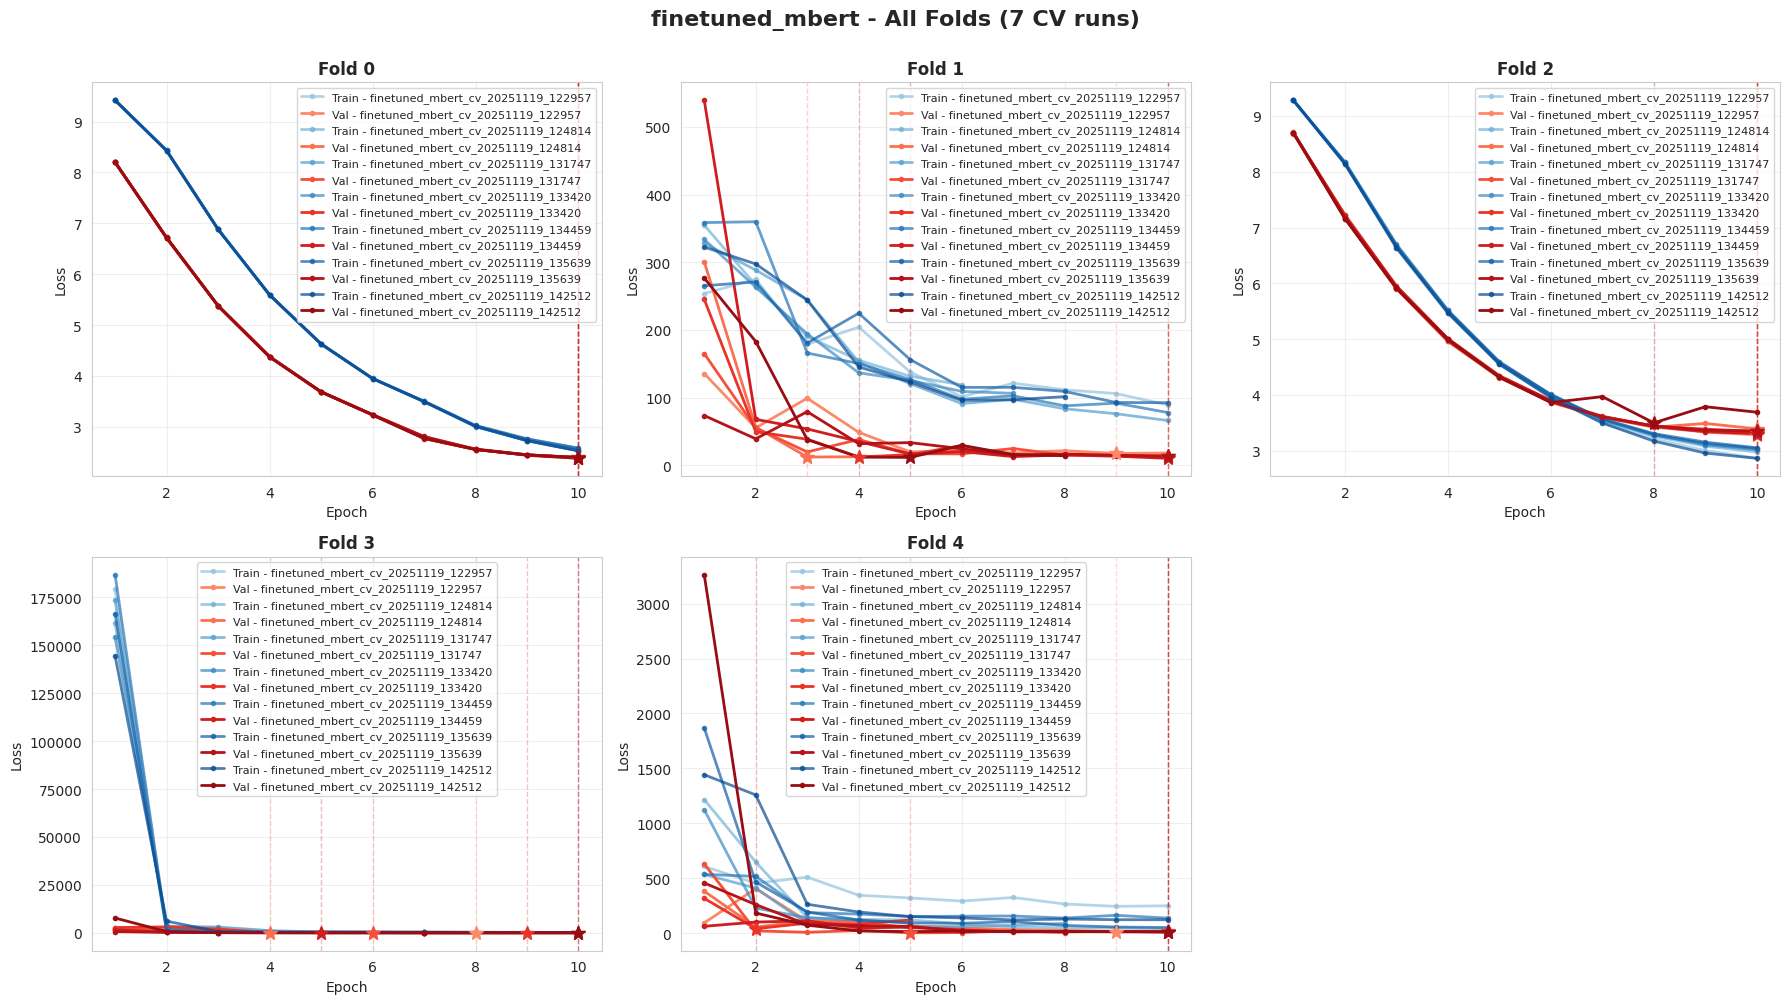

In [9]:
# Select which CV files to visualize (can select multiple)
if cv_history_files:
    # Specify indices of files to compare (e.g., [0] for first file, [0, 1] for first two files)
    CV_FILE_INDICES = list(
        range(len(cv_history_files))
    )  # Modify this list to select multiple files

    cv_data_list = []

    for idx in CV_FILE_INDICES:
        if idx < len(cv_history_files):
            selected_file = cv_history_files[idx]

            print(f"Loading CV training history from: {selected_file.name}")

            with open(selected_file, "r") as f:
                cv_data = json.load(f)

            # Add filename for labeling
            cv_data["filename"] = selected_file.stem
            cv_data_list.append(cv_data)

            print(f"  Model: {cv_data['model']}, Folds: {cv_data['n_splits']}")

    print(f"\nPlotting {len(cv_data_list)} CV run(s)...\n")
    plot_all_folds_for_multiple_cv(cv_data_list)
else:
    print("No CV training history files found!")

### Single training runs (no CV)

In [10]:
# Find single training run history files (non-CV)
train_history_files = sorted(list(TRAINING_HISTORY_DIR.glob("*_train_*.json")))
print(f"Found {len(train_history_files)} training history files:")
for f in train_history_files:
    print(f"  - {f.name}")

Found 18 training history files:
  - finetuned_mbert_train_20251119_100119.json
  - finetuned_mbert_train_20251119_100547.json
  - finetuned_mbert_train_20251119_110627.json
  - finetuned_mbert_train_20251119_111007.json
  - finetuned_mbert_train_20251119_111427.json
  - finetuned_mbert_train_20251119_111743.json
  - finetuned_mbert_train_20251119_112104.json
  - finetuned_mbert_train_20251119_112433.json
  - finetuned_mbert_train_20251119_112815.json
  - finetuned_mbert_train_20251119_114956.json
  - finetuned_mbert_train_20251119_115321.json
  - finetuned_mbert_train_20251119_115641.json
  - finetuned_mbert_train_20251119_115929.json
  - finetuned_mbert_train_20251119_120835.json
  - finetuned_mbert_train_20251119_121330.json
  - finetuned_mbert_train_20251119_121555.json
  - finetuned_mbert_train_20251119_121831.json
  - finetuned_mbert_train_20251119_122123.json


Loading training history from: finetuned_mbert_train_20251119_100119.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_100547.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_110627.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_111007.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_111427.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_111743.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_112104.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_112433.json
  Model: finetuned_mbert, Epochs: 10
Loading training history from: finetuned_mbert_train_20251119_112815.json
  Model: finetuned_mbert, Epochs: 10
L

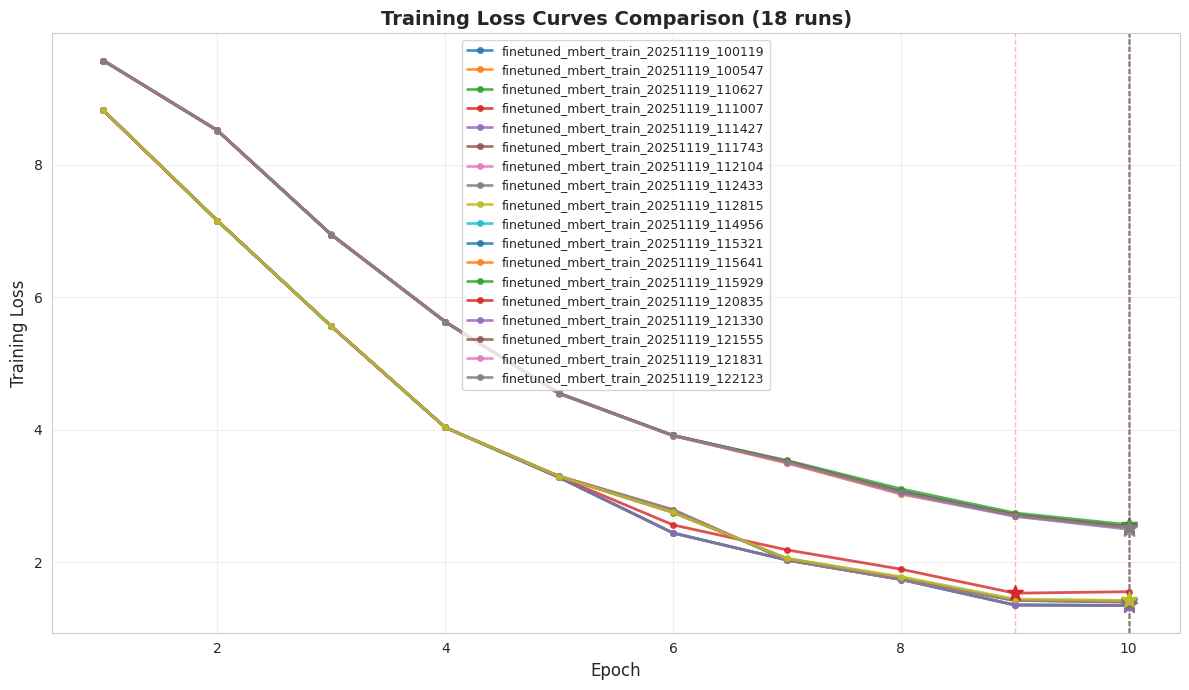


Plotted 18 training run(s)


In [11]:
# Select which training files to visualize and plot them together
if train_history_files:
    # Specify indices of files to compare (e.g., [0] for first file, [0, 1] for first two files)
    TRAIN_FILE_INDICES = list(
        range(len(train_history_files))
    )  # Modify this list to select multiple files

    fig, ax = plt.subplots(figsize=(12, 7))

    # Generate color palette
    n_files = len(TRAIN_FILE_INDICES)
    colors = cm.tab10(np.linspace(0, 1, min(n_files, 10)))

    for idx, file_idx in enumerate(TRAIN_FILE_INDICES):
        if file_idx < len(train_history_files):
            selected_file = train_history_files[file_idx]

            print(f"Loading training history from: {selected_file.name}")

            with open(selected_file, "r") as f:
                train_data = json.load(f)

            model_name = train_data.get("model", "Unknown")
            train_losses = train_data.get("train_losses", [])

            if train_losses:
                epochs = list(range(1, len(train_losses) + 1))
                color = colors[idx % len(colors)]

                ax.plot(
                    epochs,
                    train_losses,
                    "-o",
                    color=color,
                    linewidth=2,
                    markersize=4,
                    label=f"{selected_file.stem}",
                    alpha=0.8,
                )

                # Mark best epoch if available
                if "best_epoch" in train_data:
                    best_epoch = train_data["best_epoch"]
                    best_loss = train_data.get("best_train_loss")
                    if best_loss is not None:
                        ax.axvline(
                            x=best_epoch,
                            color=color,
                            linestyle="--",
                            alpha=0.3,
                            linewidth=1,
                        )
                        ax.plot(
                            best_epoch,
                            best_loss,
                            "*",
                            color=color,
                            markersize=12,
                            zorder=5,
                        )

                print(f"  Model: {model_name}, Epochs: {len(train_losses)}")

    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Training Loss", fontsize=12)
    ax.set_title(
        f"Training Loss Curves Comparison ({n_files} runs)",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nPlotted {len(TRAIN_FILE_INDICES)} training run(s)")
else:
    print("No training history files found!")